In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay)
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree # for tree.plot_tree()
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV)

from scipy.stats import uniform

# Model Performance Assessment, Hyperparameter Tuning, Cross-Validation

## Model Performance Assessment

### Confusion Matrix

In [11]:
# make fake data:       4 TN,   2 FP,   1 FN,      3 TP
y     = np.array([0, 0, 0, 0,   0, 0,      1,   1, 1, 1])
y_hat = np.array([0, 0, 0, 0,   1, 1,      0,   1, 1, 1])
M = confusion_matrix(y_true=y, y_pred=y_hat)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M, index=['actual 0', 'actual 1'], columns=['predict 0', 'predict 1']) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'confusion matrix:\n{df}')


confusion matrix:
          predict 0  predict 1
actual 0          4          2
actual 1          1          3


In [4]:
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'TN={TN}, FP={FP}, FN={FN}, TP={TP}')

TN=4, FP=2, FN=1, TP=3


### Precision, Recall, Accuracy

In [13]:
precision = precision_score(y_true=y, y_pred=y_hat)
recall = recall_score(   y_true=y, y_pred=y_hat)
accuracy = accuracy_score(y_true=y, y_pred=y_hat)
print(f'precision={precision}, recall={recall}, accuracy={accuracy}')

precision=0.6, recall=0.75, accuracy=0.7


### Area under ROC Curve (AUC)

#### Preface: True Positive Rate, False Positive Rate (on data above)

In [15]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print(f'TPR={TPR:.3}, FPR={FPR:.3}')

TPR=0.75, FPR=0.333


Now we make an ROC curve.

In [18]:
df = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/mtcars.csv', index_col=0)
feature_names = ['mpg', 'cyl', 'wt']
X = df[feature_names]
y = df['am']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Accuracy on test data is 0.875.
Or, via accuracy_score(), it is also 0.875.


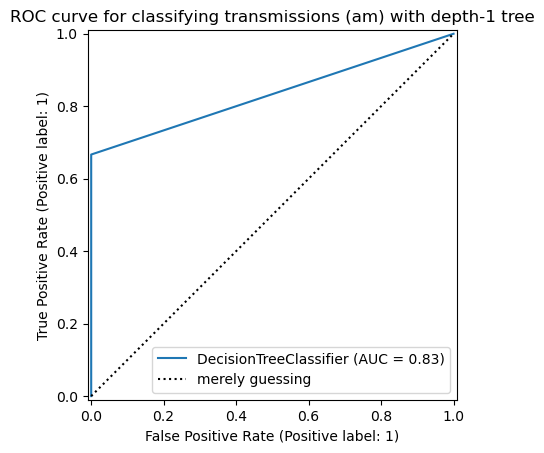

In [20]:
# train SVM on training data; make ROC curve on test data
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing') # add diagonal line
plt.title('ROC curve for classifying transmissions (am) with depth-1 tree')
plt.legend()
print(f'Accuracy on test data is {clf.score(X_test, y_test):.3}.')
print(f'Or, via accuracy_score(), it is also {accuracy_score(y_test, clf.predict(X_test)):.3}.')


In [22]:
# calculate AUC without the help of RocCurveDisplay.from_estimator()
probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
accuracy = clf.score(X_test, y_test)
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)
print(f'Area under ROC curve on test data is {auc:.3}.')

Area under ROC curve on test data is 0.833.


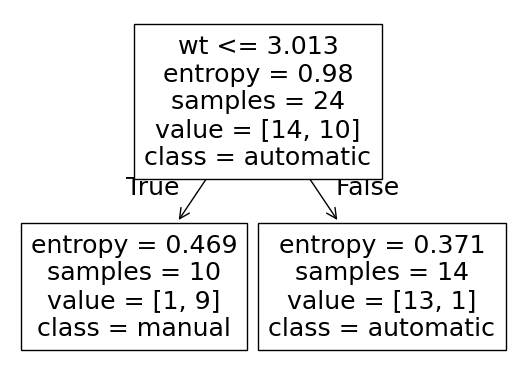

In [24]:
# look at tree--from where did ROC curve's corner come?
_ = tree.plot_tree(clf, feature_names=feature_names, class_names=['automatic', 'manual'])


#### Now, for understanding, repeat the last plot, but show that the points on the curve came from roc_curve():

For reference, 9/10=0.9 and 1/14=0.0714
thresholds=[  inf 0.9   0.071],
FPR=[0. 0. 1.],
TPR=[0.    0.667 1.   ]
y_test:
[0 0 0 1 0 0 1 1]
y_hat for threshold inf:
[0 0 0 0 0 0 0 0]
y_hat for threshold 0.9:
[0 0 0 1 0 0 0 1]
y_hat for threshold 0.0714:
[1 1 1 1 1 1 1 1]


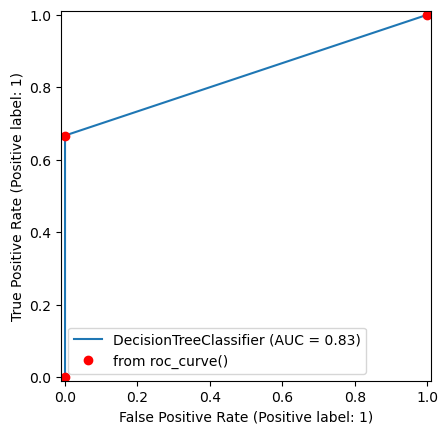

In [26]:
FPR, TPR, thresholds = roc_curve(y_true=y_test, y_score=probability_y_is_1)
print(f'For reference, 9/10={9/10:.3} and 1/14={1/14:.3}')
with np.printoptions(precision=3): # set precision for this block only
    print(f'thresholds={thresholds},\nFPR={FPR},\nTPR={TPR}')

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot(FPR, TPR, 'or', label='from roc_curve()')
_ = plt.legend(),
print('y_test:')
print(y_test.to_numpy())
for i in range(len(thresholds)):
    print(f'y_hat for threshold {thresholds[i]:.3}:')
    print((clf.predict_proba(X_test)[:, 1] >= thresholds[i]) + 0) # '+ 0' to convert to int


### Cross-Validation

In [28]:
print(f'Training accuracy is {clf.score(X_train, y_train):.3}.')
scores = cross_val_score(clf, X, y)
with np.printoptions(precision=2): # set precision for this block only
    print(f'Cross-validation scores={scores}, mean={np.mean(scores):.3}')
print(f'Test accuracy is {clf.score(X_test, y_test):.3}.')

Training accuracy is 0.917.
Cross-validation scores=[1.   0.71 1.   0.67 0.83], mean=0.843
Test accuracy is 0.875.


Notice that training accuracy over-estimated test accuracy (while the cross-validation
accuracy under-estimated it, which I prefer but do not like).

### Hyperparameter Tuning

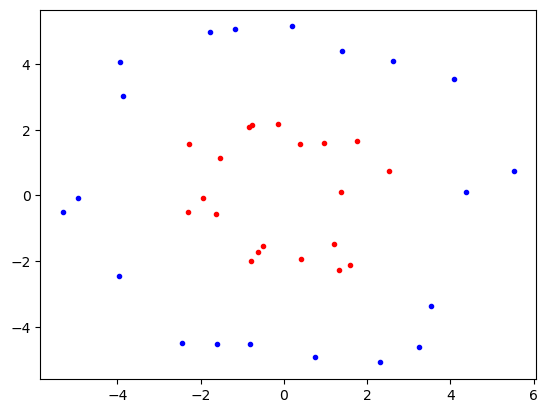

In [32]:
# reuse concentric circles data from SVM kernel trick demo; first display data
df = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/circles.csv')
X = df[['x0', 'x1']]
y = df.y
plt.plot(df.x0[y == 0], df.x1[y == 0], '.r', label='0')
_ = plt.plot(df.x0[y == 1], df.x1[y == 1], '.b', label='1')


#### Grid search

In [ ]:
# do grid search to find which kernel/C combination works best
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 1000]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X, y)
print(f'clf.best_score_={clf.best_score_:.3}, ' +
      f'clf.best_params_={clf.best_params_}')

In [ ]:
# inspect tuning results in more detail
print(pd.DataFrame(clf.cv_results_))

In [ ]:
# repeat "inspect" line above, this time printing only most important columns
print(pd.DataFrame(clf.cv_results_).iloc[:, [6, 12]].
      sort_values(by='mean_test_score', axis=0, ascending=False))

From the mean_test_score column, it looks like either C value worked perfectly for kernel='rbf'.

#### Random search

In [ ]:
rng = np.random.default_rng(seed=0)
distributions = {
    'kernel': ('linear', 'rbf'),
    'C': uniform(loc=0, scale=1000) # uniform[loc, loc + scale]
}
clf = RandomizedSearchCV(svc, param_distributions=distributions, n_iter=10)
clf.fit(X, y)
print(f'clf.best_score_={clf.best_score_:.3}, ' +
      f'clf.best_params_={clf.best_params_}')

We just used tuning to find hyperparameters training data where we knew
what to expect (that rbf was necessary to separate the two circles
of different colors). More typically, we use tuning to find the best
hyperparameters on validation data and then test the best combination
on test data. You will practice this in homework, coming soon.
